In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_4DLorenz.recursive_LSTM_PostMeanScore_4DLorenz_T256_H05_tl_110data import \
    get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)

2


0.04909657863560971 inf


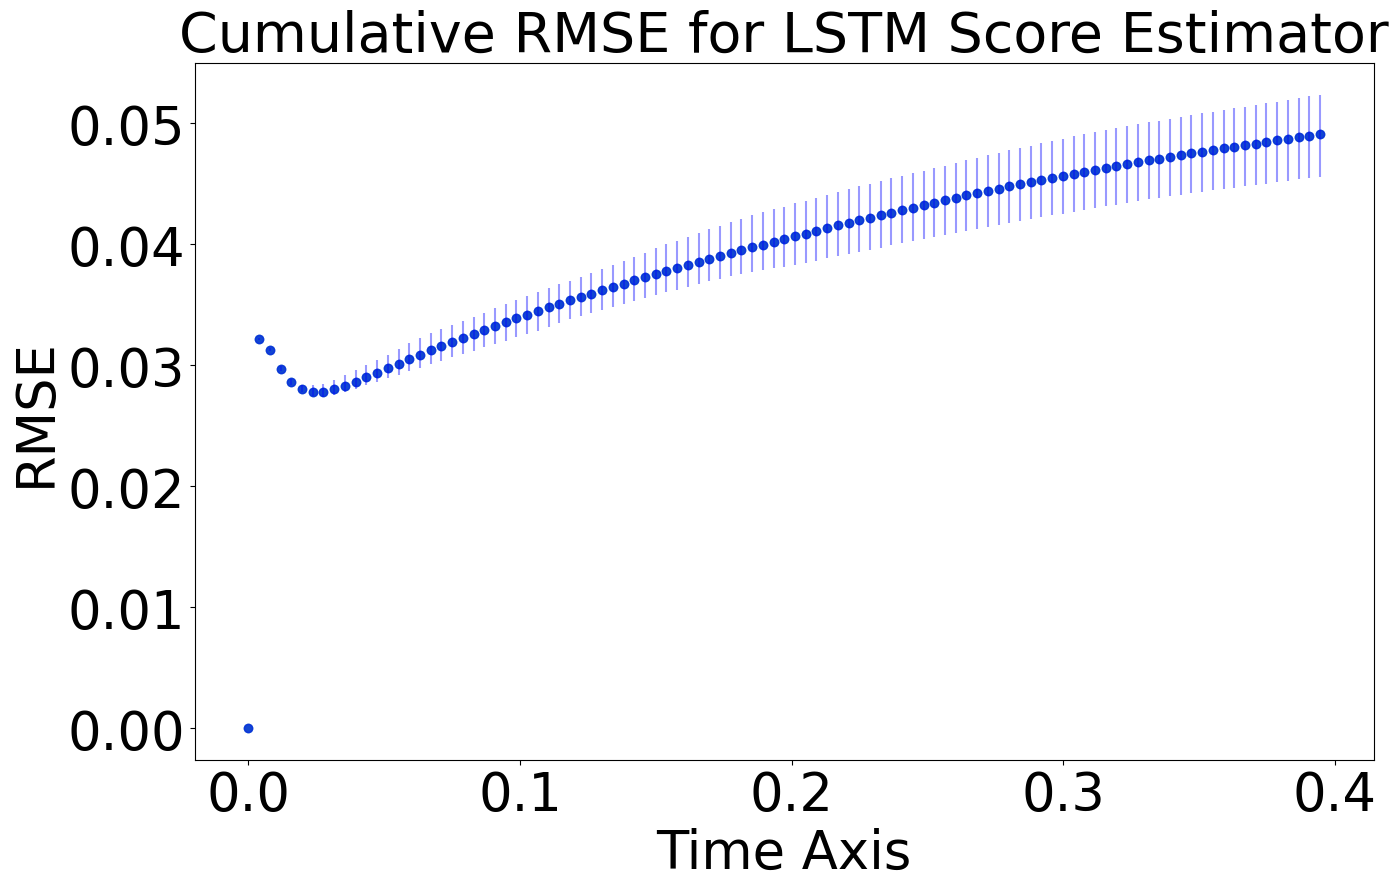

Final time cumulative RMSE local-time error 0.04909657863560971 with final IQR (0.045586146246532934, 0.05236549024744628) at Nepoch 60 for 1.25FConst

0.04412159872784148 0.04909657863560971


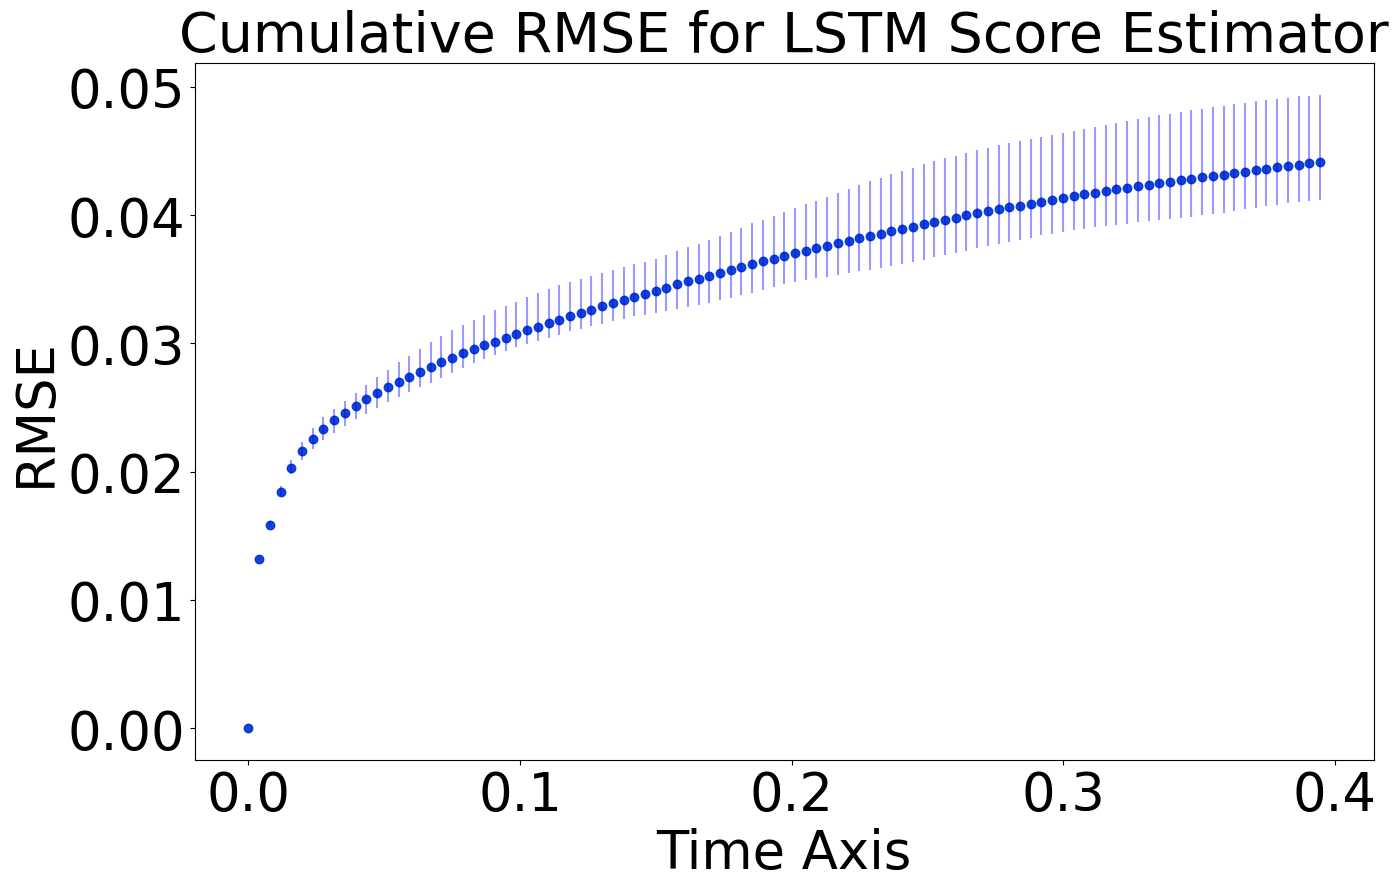

Final time cumulative RMSE local-time error 0.04412159872784148 with final IQR (0.04120367229958738, 0.049384602055973004) at Nepoch 100 for 1.25FConst

0.04502647087396716 0.04412159872784148
0.045715430405968864 0.04412159872784148
0.040844890109044865 0.04412159872784148


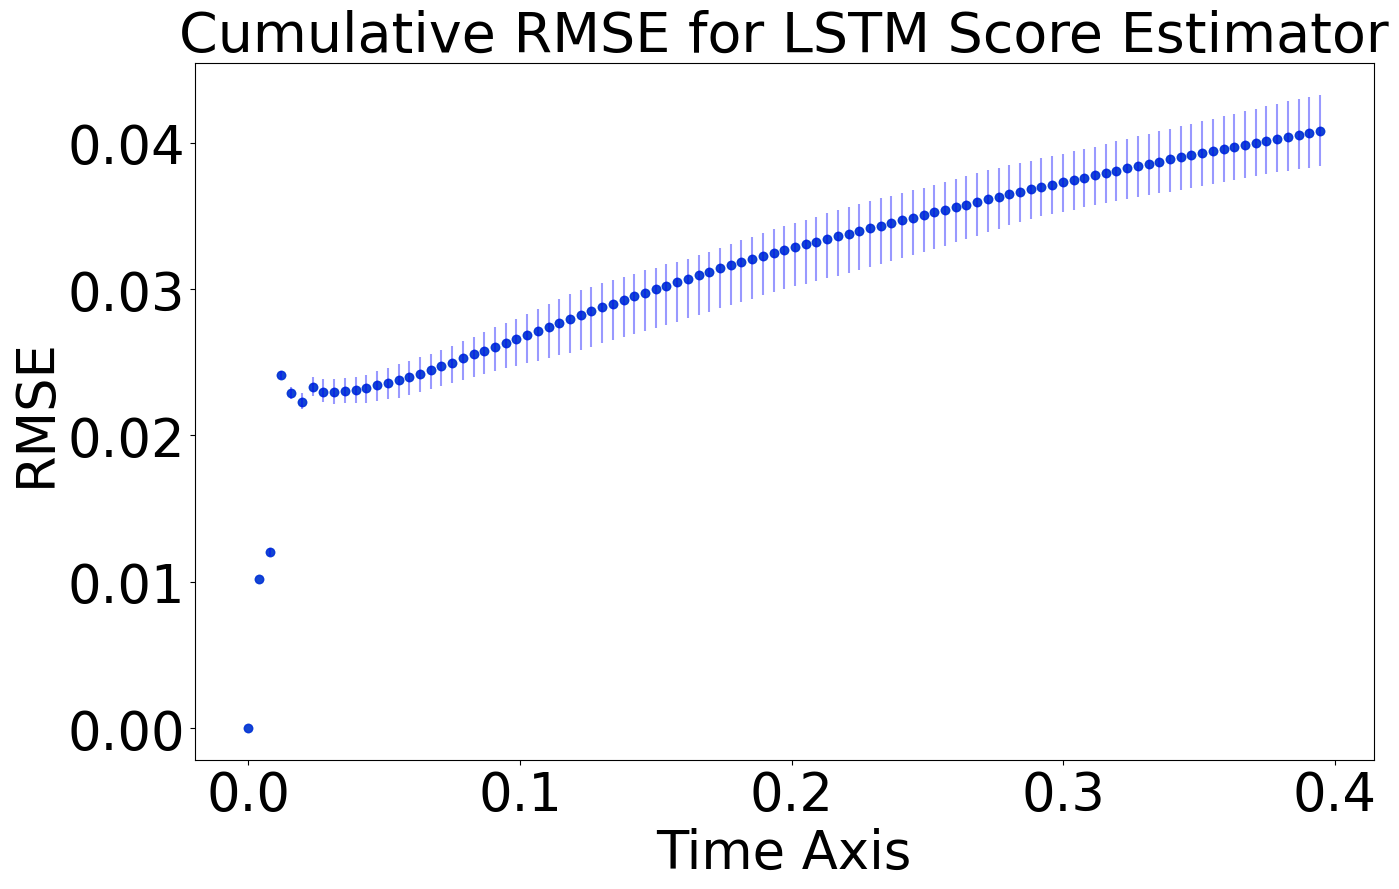

Final time cumulative RMSE local-time error 0.040844890109044865 with final IQR (0.038435947008295855, 0.043299815265734225) at Nepoch 960 for 1.25FConst

0.04480049586289029 0.040844890109044865
0.04421548329832546 0.040844890109044865
0.04493846817630116 0.040844890109044865
0.04076260288281945 0.040844890109044865


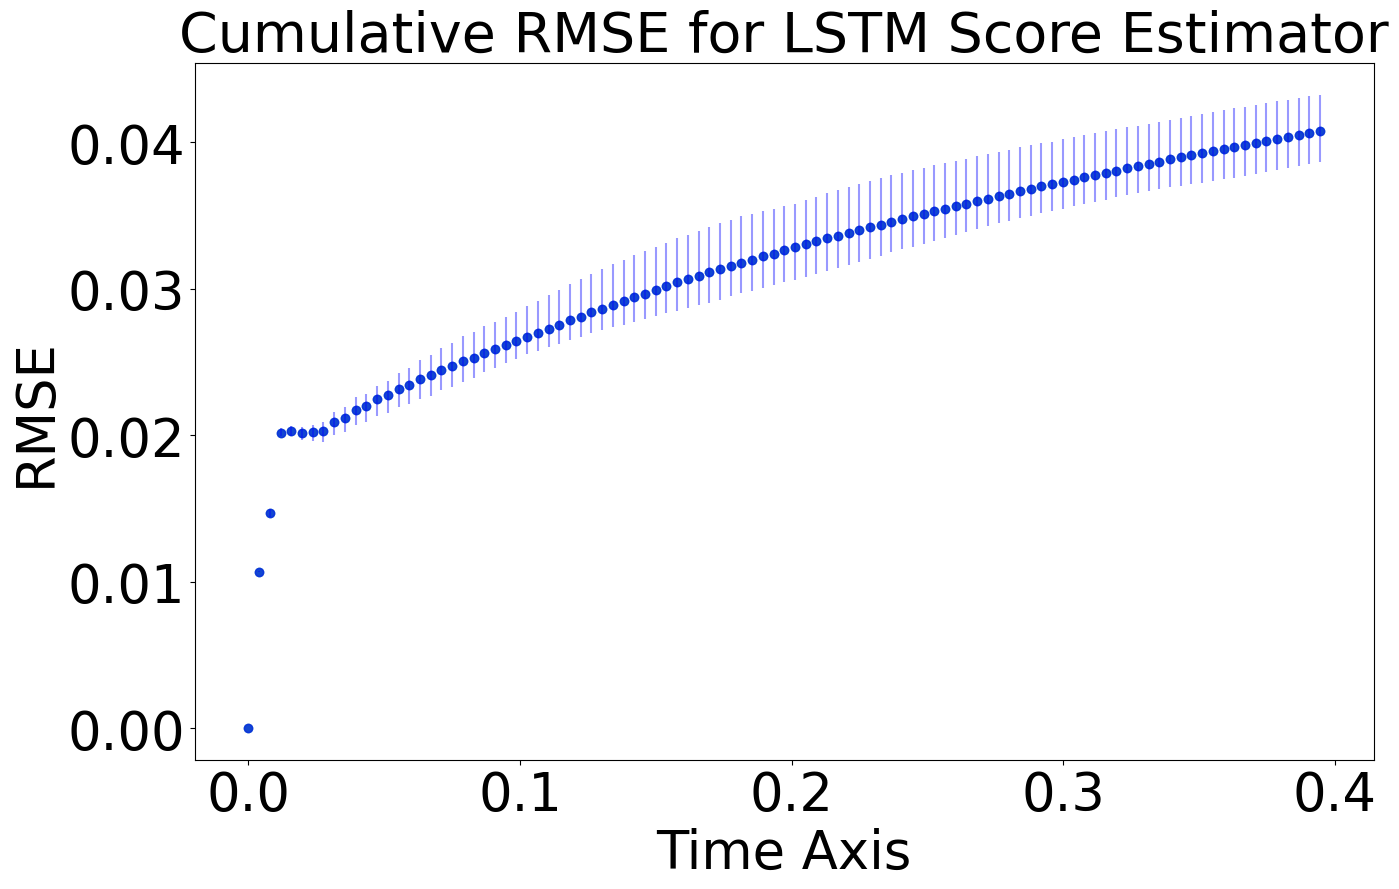

Final time cumulative RMSE local-time error 0.04076260288281945 with final IQR (0.03866993724279753, 0.04325664337918903) at Nepoch 6920 for 1.25FConst

0.04022938299045149 0.04076260288281945


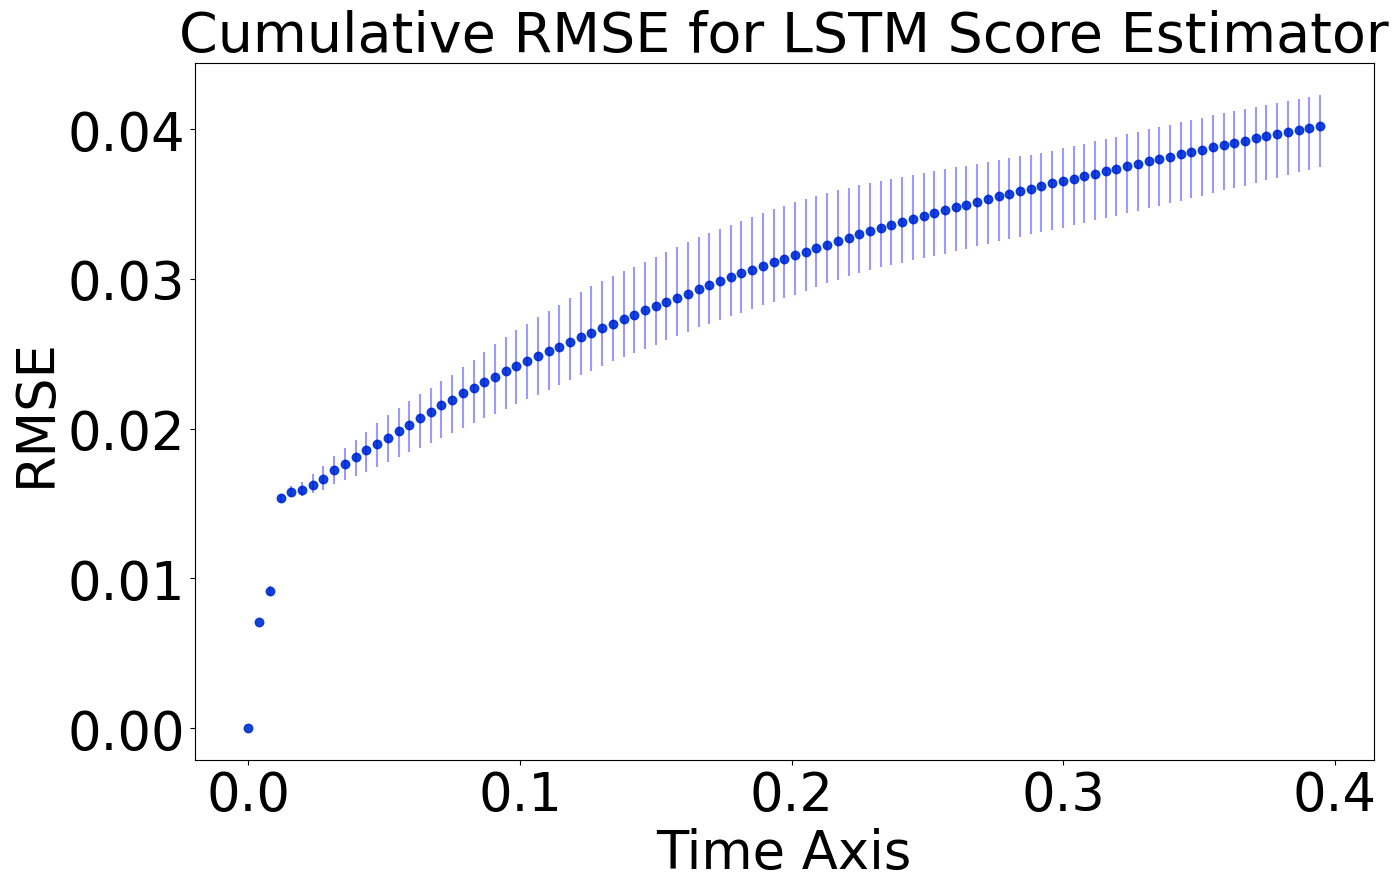

Final time cumulative RMSE local-time error 0.04022938299045149 with final IQR (0.03747044250070339, 0.0423122404296803) at Nepoch 7190 for 1.25FConst

0.03989174724955993 0.04022938299045149


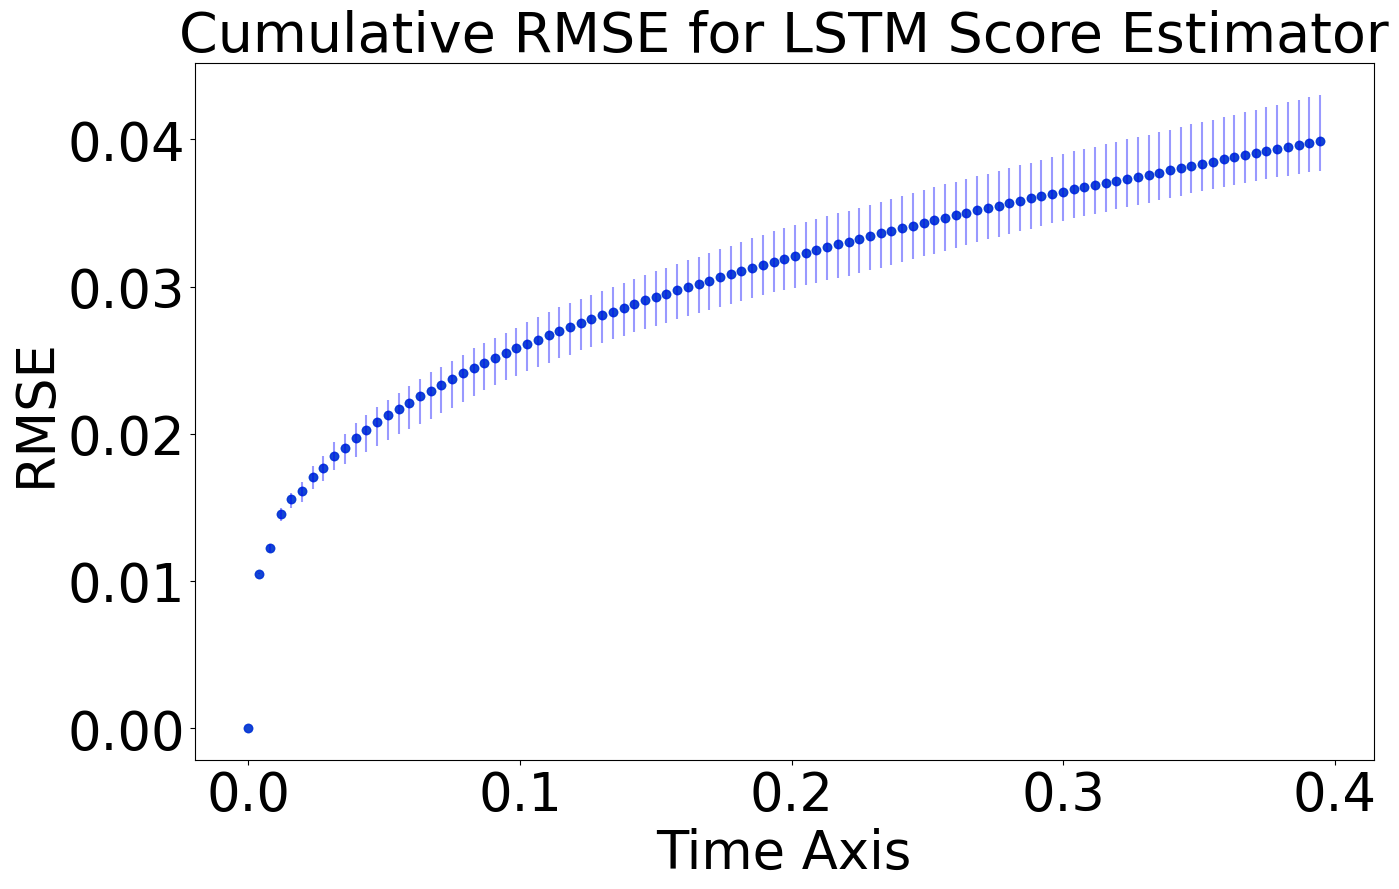

Final time cumulative RMSE local-time error 0.03989174724955993 with final IQR (0.03786669343019674, 0.0430348120826568) at Nepoch 8190 for 1.25FConst

0.04050497970354755 0.03989174724955993


In [9]:
curr_rmse = np.inf
toSave = True
for Nepoch in config.max_epochs:
    try:
        num_diff_times = 1
        save_path = (
                project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_{config.ndims}DLorenz_OOSDriftTrack_{Nepoch}Nep_tl{config.tdata_mult}data_{config.t0}t0_{config.deltaT:.3e}dT_{num_diff_times}NDT_{config.loss_factor}LFac_{round(config.forcing_const,3)}FConst").replace(
            ".", "")
        all_true_states = np.load(save_path + "_global_true_states.npy")/np.sqrt(config.deltaT)
        all_local_states= np.load(save_path + "_local_states.npy")/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], curr_rmse)
        if total_local_errors[-1] < curr_rmse:
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(time_steps, total_local_errors)
            #plt.fill_between(time_steps, total_local_errors_minq, total_local_errors_maxq, color="blue", alpha=0.2, label="95% Confidence Band")
            plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)

            ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/4DLnz_OOSDriftTrack_{Nepoch}Nep_PM_LSTM_{config.forcing_const}FConst").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at Nepoch {Nepoch} for {config.forcing_const}FConst\n")
    except FileNotFoundError as e:
        continue